In [ ]:
pip install pygam

In [39]:
#импортируем библиотеки
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import statsmodels.formula.api as sf
import numpy as np
from pygam import GAM, s, f, LogisticGAM

In [51]:
#считываем данные
df = pd.read_excel(r'g:\Yandex\Задание_вып.xls', sheet_name='Мини моделирование', header=1)

In [52]:
#немного переименовываем колонки для удобства работы
df.rename(columns={'Общие конверсии':'Общие_конверсии',
                     'Автобусы/Кинотеатры/Лифты/Метро OTS':'Автобусы',
                     'ООН/Радио/Транспорт/DООН/Digital/Indoor OTS':'ООН',
                  'Интерес к поиску работы':'поиск_работы',
                  'Интерес к бренду':'бренд',
                  'Интерес к брендам конкурентов':'конкуренты',
                  'Индекс самоизоляции':'самоизоляции',
                  'Безработица_Все гео':'Безработица',
                  'Гос праздники + НГ':'праздники',
                  'Созданные компании':'Созданные',
                  'Ликвидированные компании':'Ликвидированные',
                  'Запросы Гугл Трендс':'Гугл_Трендс'}, inplace=True)

In [92]:
y = df['Общие_конверсии']

In [93]:
X0=df.drop(['Общие_конверсии'], axis = 1)

In [94]:
X=df.drop(['Общие_конверсии', 'Дата'], axis = 1)

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
# сплитим данные на train/test в пропорции 80/20
X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, 
                                              random_state=42)

In [97]:
df.columns

Index(['Дата', 'Google_performance_shows', 'Yandex_performance_shows',
       'YouTube_shows', 'MyTarget_shows', 'Native_Roll_охваты', 'IVI_Показы',
       'TВ_Рейтинги', 'ФБ_охваты', 'ВК_показы', 'Автобусы', 'ООН',
       'поиск_работы', 'бренд', 'конкуренты', 'самоизоляции', 'Безработица',
       'праздники', 'Созданные', 'Ликвидированные', 'Гугл_Трендс',
       'Общие_конверсии'],
      dtype='object')

In [98]:
#Удалим сильно коррелируюшие столбцы - (определили в Excel)
X1=X.drop(['Ликвидированные', 'конкуренты'], axis = 1)
# X2=X1.drop(['ООН/Радио/Транспорт/DООН/Digital/Indoor OTS', 'Интерес к поиску работы'], axis = 1)
# X3=X2.drop(['Индекс самоизоляции'], axis = 1)
# X4=X3.drop(['Созданные компании'], axis = 1)
# X5=X4.drop(['Запросы Гугл Трендс'], axis = 1)
# X6=X5.drop(['Google_performance_shows', 'MyTarget_shows'], axis = 1)
# X7=X6.drop(['ФБ_охваты'], axis = 1)


In [99]:
X1_test=X_test.drop(['Ликвидированные', 'конкуренты'], axis = 1)

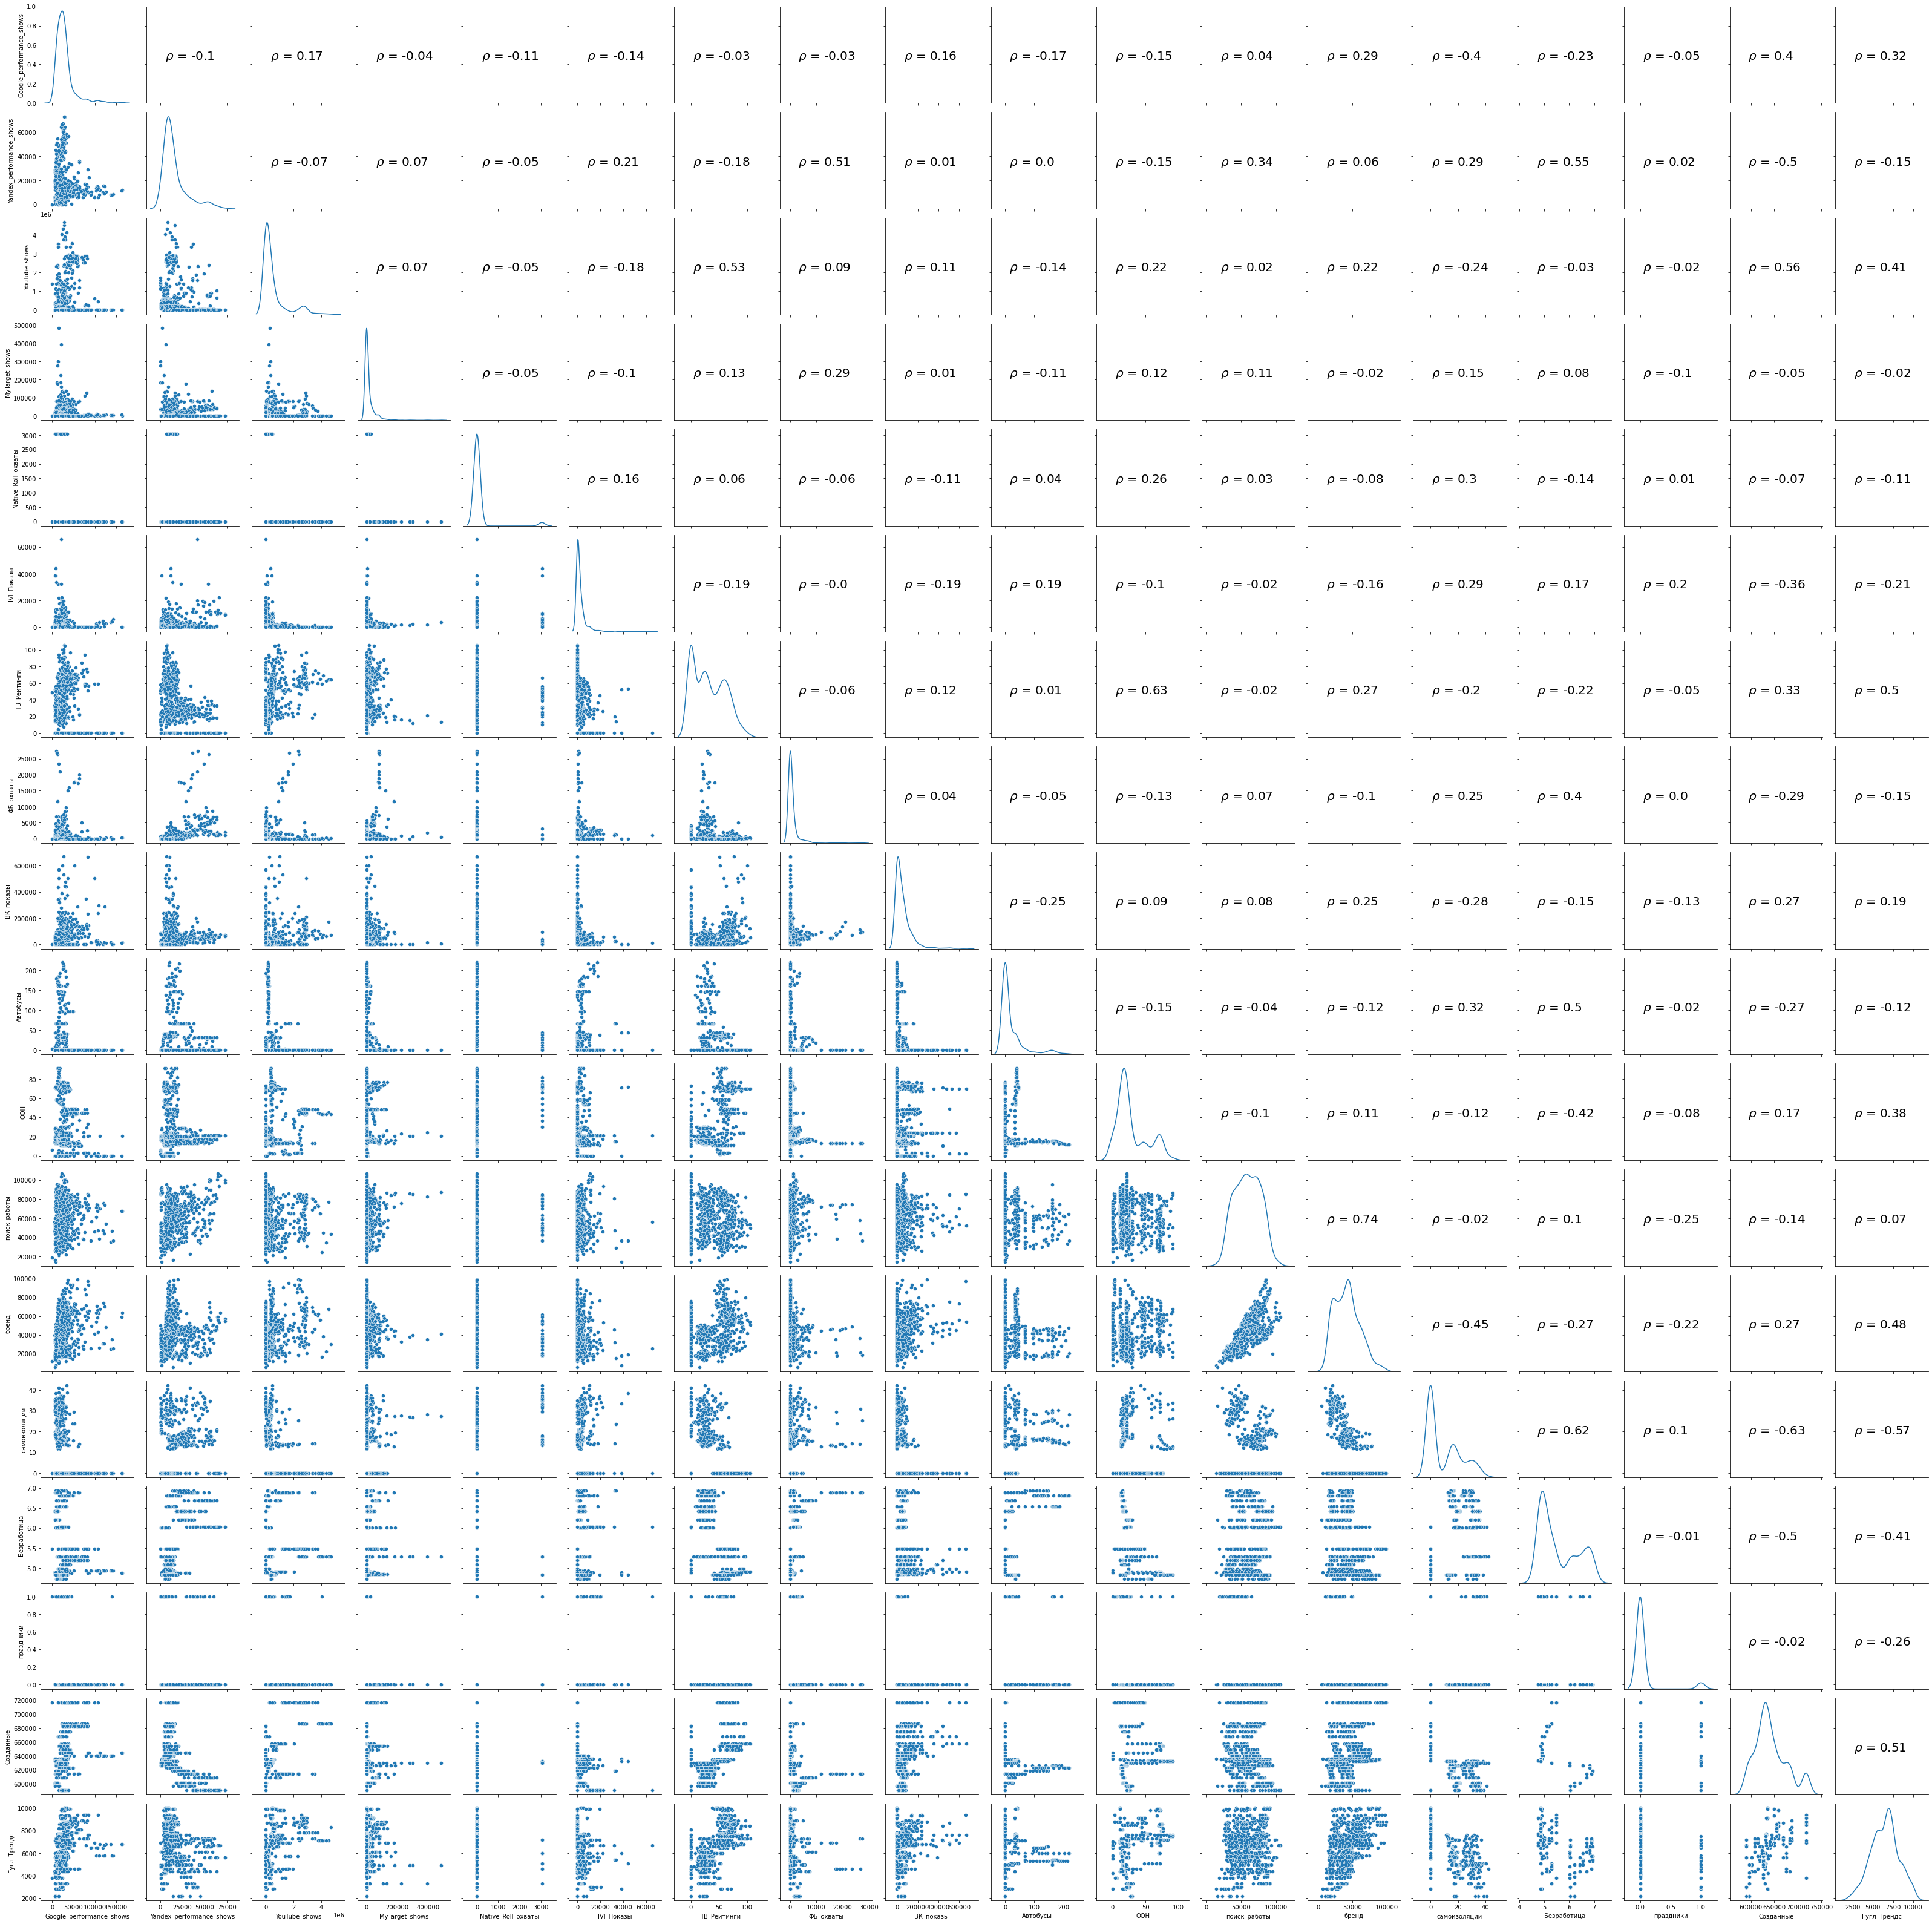

In [109]:
#попарные скаттерплоты независимых переменных

# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.45), size = 20, xycoords = ax.transAxes)

g = sns.PairGrid(X1, diag_sharey=False)
# g.map_upper(sns.scatterplot)
g.map_upper(corr)
g.map_lower(sns.scatterplot)
g.map_diag(sns.kdeplot)

In [100]:
first_time = GAM().fit(X1, y) 

In [81]:
X1.columns

Index(['Google_performance_shows', 'Yandex_performance_shows', 'YouTube_shows',
       'MyTarget_shows', 'Native_Roll_охваты', 'IVI_Показы', 'TВ_Рейтинги',
       'ФБ_охваты', 'ВК_показы', 'Автобусы', 'ООН', 'поиск_работы', 'бренд',
       'самоизоляции', 'Безработица', 'праздники', 'Созданные', 'Гугл_Трендс'],
      dtype='object')

In [101]:
first_time.summary() #общее описание модели

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     142.876
Link Function:                     IdentityLink Log Likelihood:                                -12493.4557
Number of Samples:                          609 AIC:                                            25274.6634
                                                AICc:                                           25364.4851
                                                GCV:                                        549619001.0632
                                                Scale:                                       323842244.059
                                                Pseudo R-Squared:                                    0.978
Feature Function                  Lam

<ipython-input-101-4d0ef17e9b77>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  first_time.summary() #общее описание модели


In [102]:
def part_plot(model, X, y_label = 'Общие конверсии'):
    
    for i, term in enumerate(model.terms): #проходимся циклом по всем предиктором с их нумерацией
        if term.isintercept:
            continue #интерсепт не рисуем

        XX = model.generate_X_grid(term=i) #задаём разрешение для конкретного предиктора
        pdep, confi = model.partial_dependence(term=i, X=XX, width=0.95) #расчёт линии и доверительного интервала (95%)

        plt.figure() #задаём график
        plt.plot(XX[:, term.feature], pdep) #рисуем линию
        plt.plot(XX[:, term.feature], confi, c='r', ls='--') #рисуем доверительный интервал
        plt.title(X.columns[i]) #заголовок
        plt.ylabel(y_label) #подпись y-оси
        plt.show()

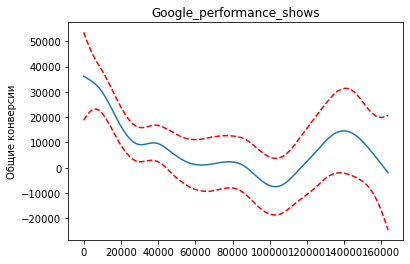

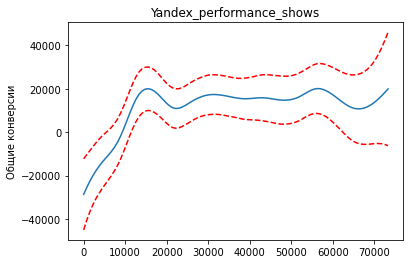

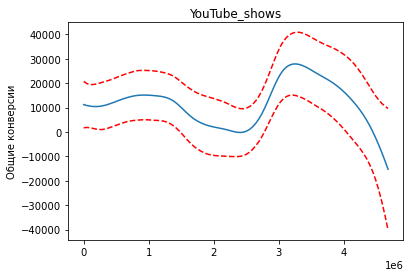

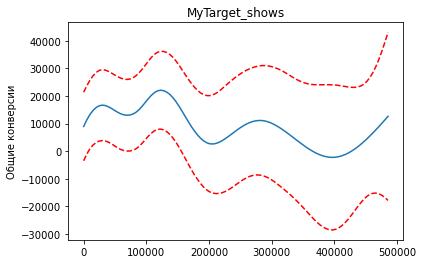

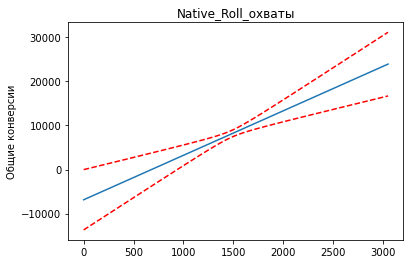

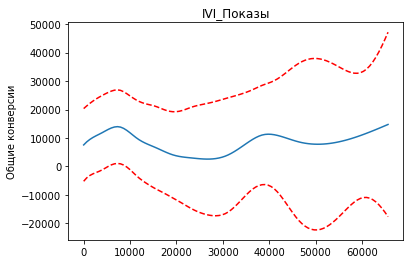

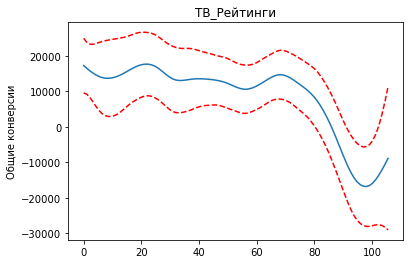

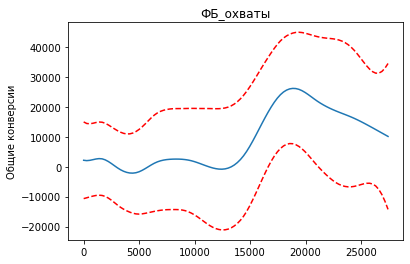

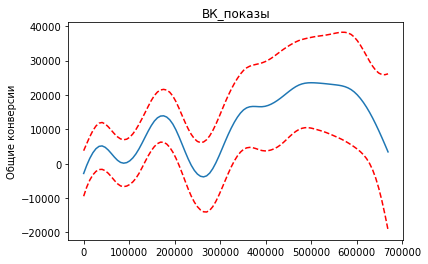

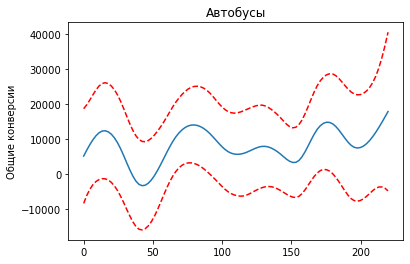

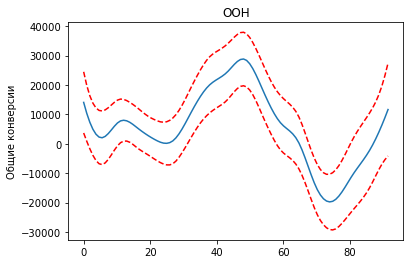

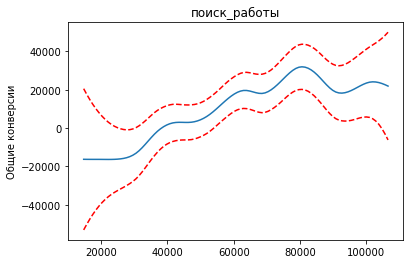

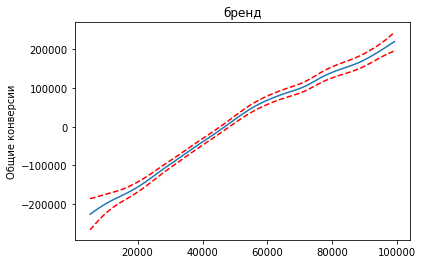

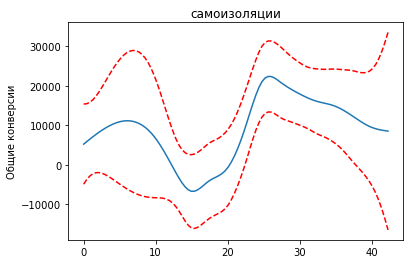

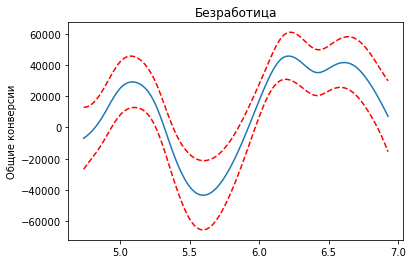

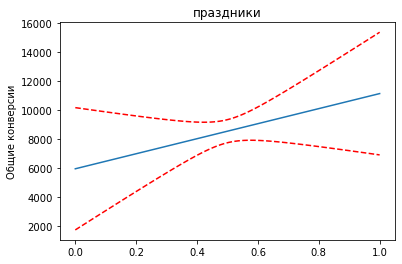

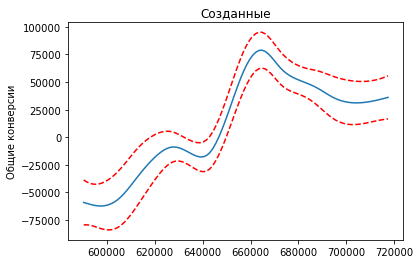

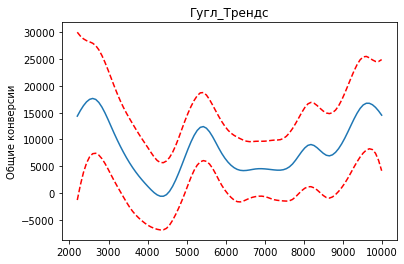

In [39]:
part_plot(first_time, X1)

In [103]:
#убираем статистически незначимые предикторы

X2=X1.drop([#'Google_performance_shows', 'Yandex_performance_shows',
       'YouTube_shows', 'MyTarget_shows', #'Native_Roll_охваты', 
        'IVI_Показы',       'TВ_Рейтинги', 'ФБ_охваты', 
        #'ВК_показы', 
        'Автобусы', 
        #'ООН', 'поиск_работы', 'бренд', 'самоизоляции', 'Безработица',
        'праздники', 
        #'Созданные', 
        'Гугл_Трендс'], axis = 1)


In [104]:
X2_test=X1_test.drop([#'Google_performance_shows', 'Yandex_performance_shows',
       'YouTube_shows', 'MyTarget_shows', #'Native_Roll_охваты', 
        'IVI_Показы',       'TВ_Рейтинги', 'ФБ_охваты', 
        #'ВК_показы', 
        'Автобусы', 
        #'ООН', 'поиск_работы', 'бренд', 'самоизоляции', 'Безработица',
        'праздники', 
        #'Созданные', 
        'Гугл_Трендс'], axis = 1)


In [105]:
second_time = GAM().fit(X2, y) 

In [106]:
X2.columns

Index(['Google_performance_shows', 'Yandex_performance_shows',
       'Native_Roll_охваты', 'ВК_показы', 'ООН', 'поиск_работы', 'бренд',
       'самоизоляции', 'Безработица', 'Созданные'],
      dtype='object')

In [107]:
second_time.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     86.9296
Link Function:                     IdentityLink Log Likelihood:                                -12538.1357
Number of Samples:                          609 AIC:                                            25252.1305
                                                AICc:                                           25282.2016
                                                GCV:                                        466607869.2733
                                                Scale:                                      348494559.5372
                                                Pseudo R-Squared:                                   0.9735
Feature Function                  Lam

<ipython-input-107-edd38e2088d2>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  second_time.summary()


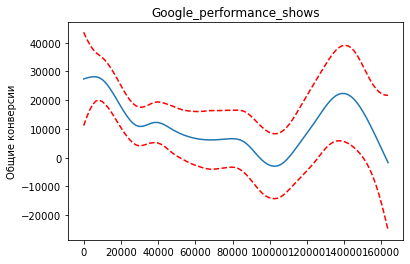

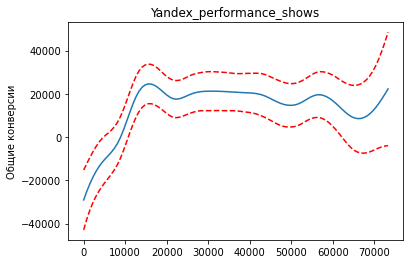

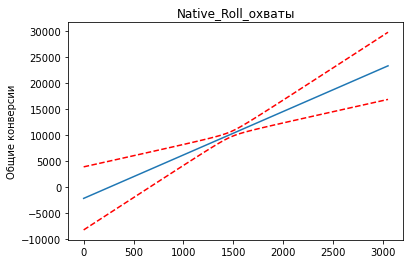

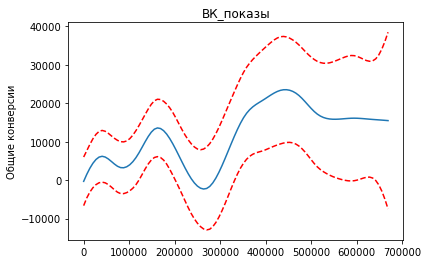

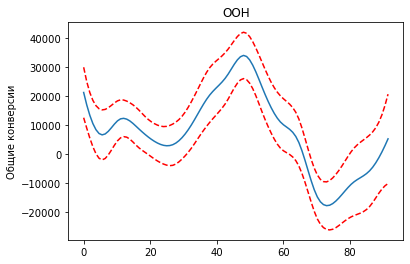

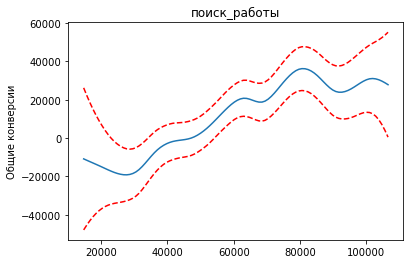

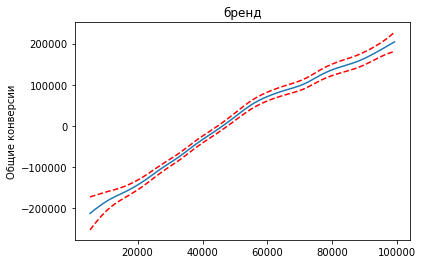

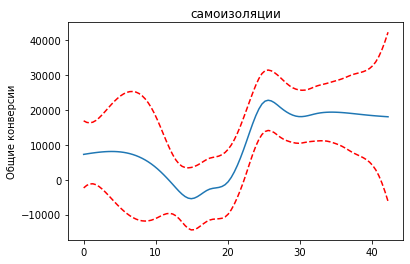

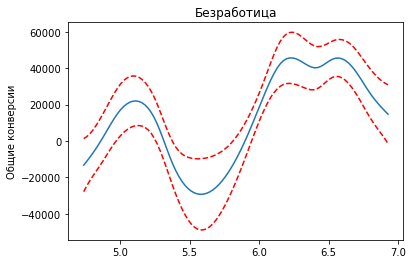

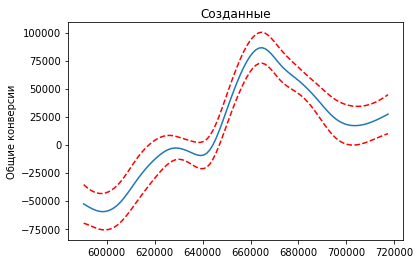

In [43]:
part_plot(second_time, X2)

In [49]:
# в Google Colab протестировано Rank = 4, 5 ,6 - результаты 5,6,4,6,6,6,...


# spline = np.arange(4, 6, 1) #от 4 до 5
# splines = [spline] * 10 #чтобы было на каждый параметр 
# model_opt_s = GAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9)). \
#                         gridsearch(X2.values, y, n_splines = splines)
# model_opt_s.summary()

In [108]:
third_time = GAM(s(0, n_splines = 5) + s(1, n_splines = 6) \
                    + s(2, n_splines = 4) + s(3, n_splines = 6) \
                    + s(4, n_splines = 6) + s(5, n_splines = 6) \
                   + s(6, n_splines = 6) + s(7, n_splines = 6) \
                   + s(8, n_splines = 6) + s(9, n_splines = 6) \
                                                               ).fit(X2, y) 

In [109]:
third_time.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     24.2241
Link Function:                     IdentityLink Log Likelihood:                                -12806.9361
Number of Samples:                          609 AIC:                                            25664.3204
                                                AICc:                                           25666.5905
                                                GCV:                                         583479640.201
                                                Scale:                                      541857234.8969
                                                Pseudo R-Squared:                                   0.9538
Feature Function                  Lam

<ipython-input-109-e428c22fdb32>:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  third_time.summary()


In [110]:
predictions = third_time.predict(X2_test)

In [111]:
#оценка метрики MSE на тестовой выборке
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, predictions)

460712159.6307866

In [52]:
#регуляризация 
lam = np.logspace(-1, 1, 3)
lams = [lam] * 10 

In [53]:
lams

[array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ]),
 array([ 0.1,  1. , 10. ])]

In [55]:
model_opt_reg = GAM(s(0, n_splines = 5) + s(1, n_splines = 6) \
                    + s(2, n_splines = 4) + s(3, n_splines = 6) \
                    + s(4, n_splines = 6) + s(5, n_splines = 6) \
                   + s(6, n_splines = 6) + s(7, n_splines = 6) \
                   + s(8, n_splines = 6) + s(9, n_splines = 6) \
                                                               ).gridsearch(X2.values, y,\
                                                                          lam = lams) 

  5% (3160 of 59049) |#                  | Elapsed Time: 0:04:53 ETA:   1:48:12

KeyboardInterrupt: 

In [ ]:
model_opt_reg.summary()

In [ ]:
part_plot(model_opt_reg, X1)

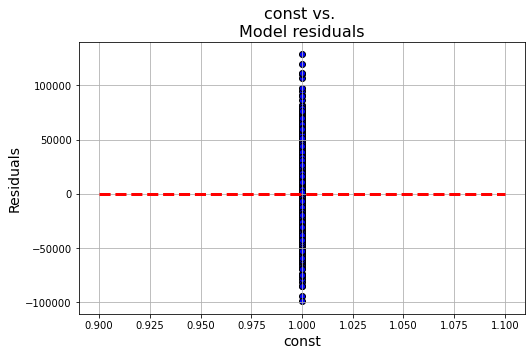

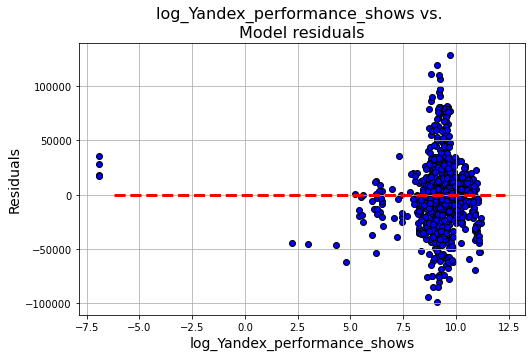

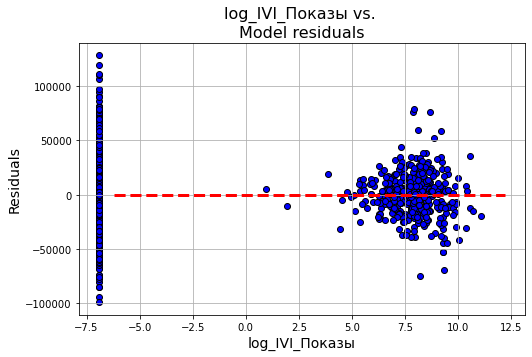

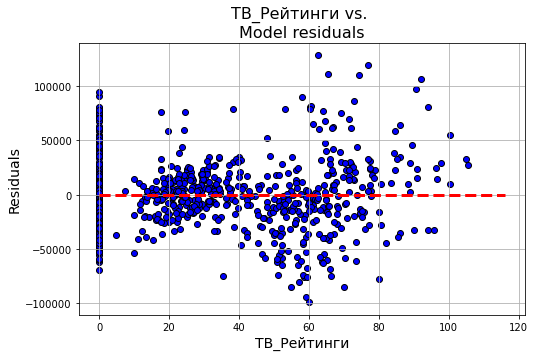

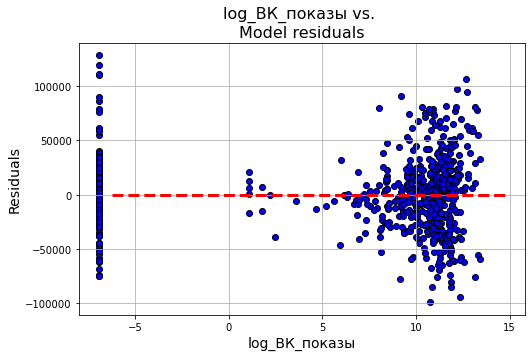

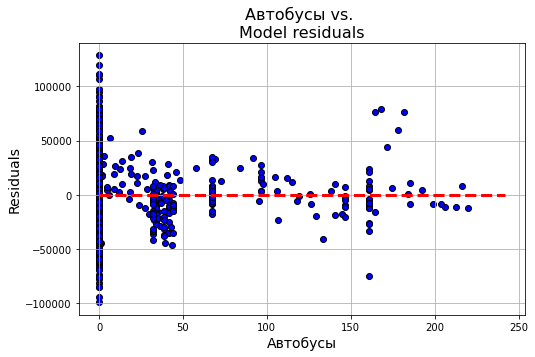

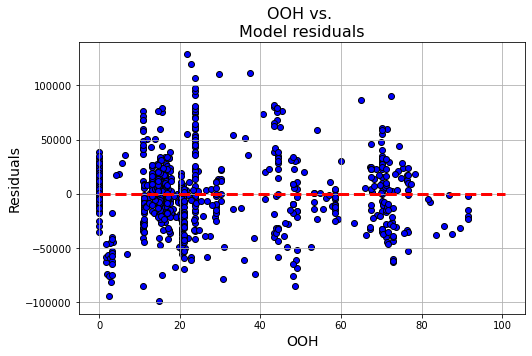

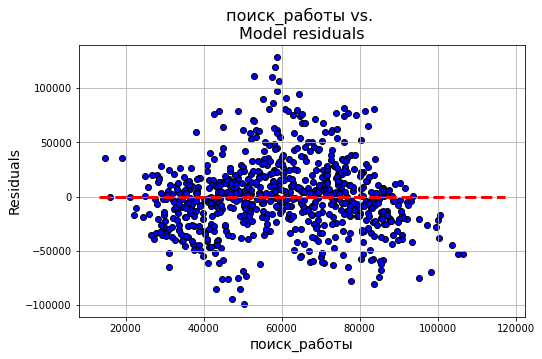

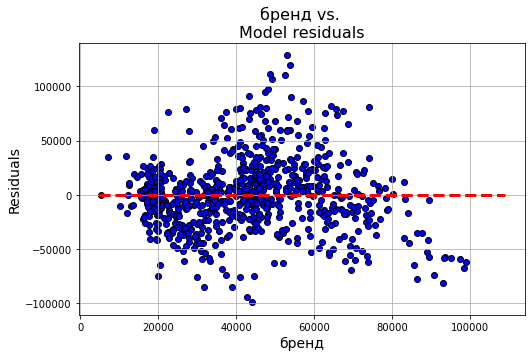

In [140]:
#графики рапределения остатков
for c in X1.columns[:-1]:
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \nModel residuals".format(c),fontsize=16)
    plt.scatter(x=X1[c],y=model.resid,color='blue',edgecolor='k')
    plt.grid(True)
    xmin=min(X1[c])
    xmax = max(X1[c])
    plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('Residuals',fontsize=14)
    plt.show()


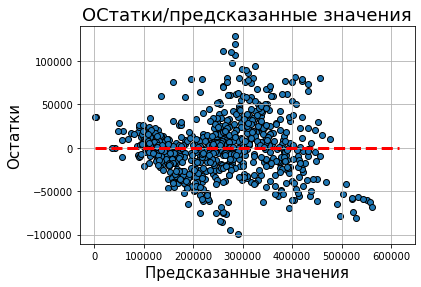

In [141]:
# график зависмости остатков от предсказанных занчений - должен 
p=plt.scatter(x=model.fittedvalues,y=model.resid,edgecolor='k')
xmin=min(model.fittedvalues)
xmax = max(model.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Предсказанные значения",fontsize=15)
plt.ylabel("Остатки",fontsize=15)
plt.title("ОСтатки/предсказанные значения",fontsize=18)
plt.grid(True)
plt.show()


ГЕТЕРОСКЕДАСТИЧНОСТЬ????????

In [31]:
from statsmodels.graphics.gofplots import qqplot

<Figure size 576x360 with 0 Axes>

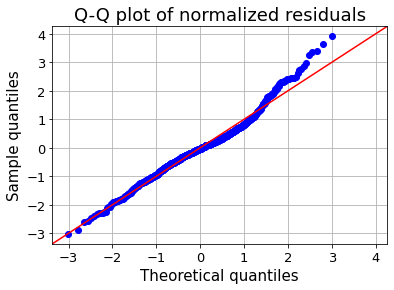

In [142]:
# -QQ-plot для остатков
plt.figure(figsize=(8,5))
fig=qqplot(model.resid_pearson,line='45',fit='True')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel("Theoretical quantiles",fontsize=15)
plt.ylabel("Sample quantiles",fontsize=15)
plt.title("Q-Q plot of normalized residuals",fontsize=18)
plt.grid(True)
plt.show()

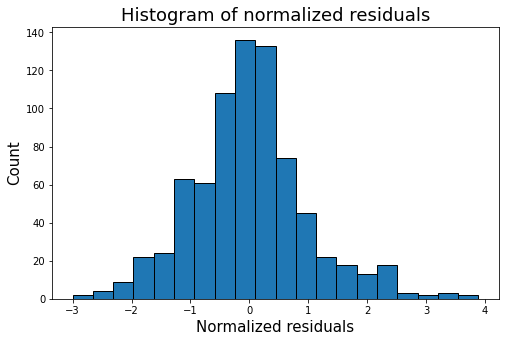

In [143]:
# ГИСТОГРАММА ОСТАТКОВ
plt.figure(figsize=(8,5))
plt.hist(model.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

In [75]:
from scipy.stats import shapiro

In [144]:
#тест Шапиро-Уилка для остатков
_,p=shapiro(model.resid)

In [145]:
p

3.558922045954205e-09

Результаты теста показывают, что остатки распредлены нормально (p<<0.01)

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [146]:
for i in range(len(X1.columns[:-1])):
    v=vif(np.matrix(X1[:-1]),i)
    print("Variance inflation factor for {}: {}".format(X1.columns[i],round(v,2)))

Variance inflation factor for const: 1270.92
Variance inflation factor for log_Yandex_performance_shows: 1.41
Variance inflation factor for log_IVI_Показы: 2.95
Variance inflation factor for TВ_Рейтинги: 2.07
Variance inflation factor for log_ВК_показы: 1.44
Variance inflation factor for Автобусы: 1.42
Variance inflation factor for ООН: 1.9
Variance inflation factor for поиск_работы: 3.72
Variance inflation factor for бренд: 3.97


Все VIF < 10, что говорит об отстутсвии мультиколлинеарности в данных.

In [79]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [147]:
inf=influence(model)

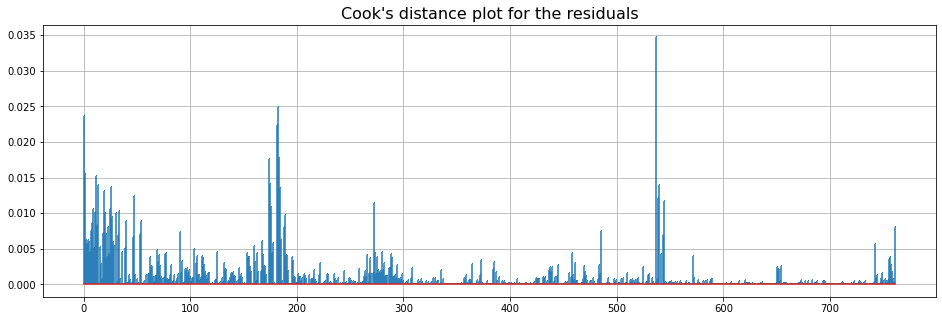

In [148]:
(c, p) = inf.cooks_distance
plt.figure(figsize=(16,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

In [151]:
df.iloc[520:570,:]

,Дата,Google_performance_shows,Yandex_performance_shows,YouTube_shows,MyTarget_shows,Native_Roll_охваты,IVI_Показы,TВ_Рейтинги,ФБ_охваты,ВК_показы,...,поиск_работы,бренд,конкуренты,самоизоляции,Безработица,праздники,Созданные,Ликвидированные,Гугл_Трендс,Общие_конверсии
520,2020-06-04,28738.80,10046.066667,195796,1992.25,0.0,3594.4,34.26,0.000000,0,...,72669.8,41382,82764,16.463909,6.547423,0,625898,1339777,6000,282172
521,2020-06-05,31153.15,9087.266667,216970,0.00,0.0,2941.0,21.06,0.000000,0,...,62981.2,35028,70056,16.252808,6.547423,0,625898,1339777,6000,232892
522,2020-06-06,26059.00,5958.000000,206542,0.00,0.0,3421.8,7.28,0.000000,0,...,38209.0,17520,35040,24.603956,6.547423,0,625898,1339777,6000,128689
523,2020-06-07,34254.00,6546.600000,184424,0.00,0.0,4421.4,41.26,0.000000,0,...,41449.6,19680,39360,29.164907,6.547423,0,625898,1339777,5000,138314
524,2020-06-08,31094.50,11579.866667,215514,0.00,0.0,2983.4,24.72,73.583333,24177,...,79797.0,46836,93672,16.366209,6.547423,0,625898,1339777,5000,313555
525,2020-06-09,30354.20,10724.800000,191562,7717.00,0.0,2687.2,12.20,98.916667,16197,...,70472.8,43656,87312,15.656812,6.547423,0,625898,1339777,5000,267993
526,2020-06-10,31830.70,10882.800000,170034,20529.50,0.0,2717.6,27.02,106.083333,10398,...,68595.4,41988,83976,15.683743,6.547423,0,625898,1339777,5000,280599
527,2020-06-11,31118.95,9373.866667,242880,25388.00,0.0,2523.8,30.64,97.500000,7269,...,60157.0,33942,67884,15.190652,6.547423,0,625898,1339777,5000,226061
528,2020-06-12,21433.20,6150.000000,140670,24870.25,0.0,2706.8,26.04,84.916667,5103,...,36933.4,18972,37944,24.977784,6.547423,1,625898,1339777,5000,132792
529,2020-06-13,19927.10,6222.933333,210272,12226.00,0.0,3316.4,18.68,100.083333,4248,...,37002.4,16590,33180,26.152422,6.547423,0,625898,1339777,5000,112486
